In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
from scipy.sparse import csr_matrix, save_npz, load_npz
import dask.dataframe as dd
import gc

def batch_cosine_similarity(dtm, batch_size=1000):
    num_rows = dtm.shape[0]
    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        yield cosine_similarity(dtm[start:end], dtm)

import psutil
def print_ram_usage(step = 0):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"[{step}] RAM Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

# # Load data (assuming data is in a CSV file, replace 'data.csv' with your actual file path)
data = pd.read_csv('../int_data/Input_patent_matrix.csv')
data

,i,county,district,subdistrict,parish,city,town,street,occupation.x,text,description,names,title,recid,occupation.y,pos2,max
0,GB187303416,MIDDLESEX,NA,NA,NA,NA,NA,47 STREET,"HISCO410, HISCO744, HISCO896,",LETTERS TO JAMES HARVEY OF HILLSIDE ESTATE V...,STILL DESIGN KIND COMMONLY COLONY DISTILL RUM ...,NaN,PATENT GB187303416A,1811640,582,455,5157
1,GB187600824,MIDDLESEX,"WELLINGTON ,","BOW , NEWTON , ROAD , WELLINGTON , BOW , ...","BOW ,",NA,NA,28TH FEBRUARY GEORGE NEWTON OF WELLINGTON ROAD,"HISCO779, HISCO951, HISCO813, HISCO896, HISCO3...",LEFT BY GEORGE NEWTON AT THE OFFICE OF THE C...,OFFICE COMMISSIONER PATENT FEBRUARY WELLINGTON...,NaN,PATENT GB187600824A,342728,959,-1,1608
2,GB187601544,NA,"BATH ,","LOOSE ,","BATH , BOX ,",BATH,NA,NA,"HISCO999, HISCO974, HISCO90, HISCO24, HISCO901...",LUBRICATING AXLES AND SHAFTS LETTERS TO MARTY...,LUBRICATE AXLE SHAFT PATENT MARTYN BATH ESQUIR...,NaN,PATENT GB187601544A,25148967,801,-1,12596
3,GB187901073,NA,NA,"MARCH , OVER , WOODBURY ,","BOX ,",DUBLIN,NA,ORMOND STREET,"HISCO410, HISCO80, HISCO744, HISCO999, HISCO83...",REGISTRATION AND INDEXING OF DEEDS C LETTERS ...,REGISTRATION INDEX DEED PATENT THOMAS ARTHUR O...,NaN,PATENT GB187901073A,17468193,722,-1,39840
4,GB187901073,NA,NA,"MARCH , OVER , WOODBURY ,","BOX ,",DUBLIN,NA,ORMOND STREET,"HISCO410, HISCO80, HISCO744, HISCO999, HISCO83...",REGISTRATION AND INDEXING OF DEEDS C LETTERS ...,REGISTRATION INDEX DEED PATENT THOMAS ARTHUR O...,NaN,PATENT GB187901073A,8909867,624,-1,39840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22139,GB191211210,YORK,NA,"ELLAND ,",NA,NA,NA,NA,NA,N LIMITED OF ROSE MOUNT IRONWORKS ELLAND ...,GAS RETORT TYPE CONTINUOUS PRINCIPAL FACILITAT...,"DEMPSTER ROBERT & SONS LTD, HERBERT JOHN TOOGOOD",IMPROVED MEANS FOR DISCHARGING VERTICAL GAS RE...,19313371,985,209,5400
22140,GB191213037,"LONDON ,","LONDON ,",NA,NA,NA,NA,31 32 BEDD STREET,"HISCO333; HISCO999, HISCO999, HISCO33, HISCO333,",OF THE FIRM OF HERBERT CO OF 31 32 BEDD STRE...,COMMUNICATION ABROAD NATIONAL CASH REGISTER CO...,REGINALD HADDAN,IMPROVEMENTS IN AND RELATING TO ADDING AND TRA...,6923327,981,219,14885
22141,GB191213039,"LONDON ,","LONDON ,",NA,NA,NA,NA,31 32 BEDD STREET,"HISCO333; HISCO999, HISCO999, HISCO33, HISCO333,",OF THE FIRM OF HERBERT CO OF 31 32 BEDD STRE...,COMMUNICATION ABROAD NATIONAL CASH REGISTER CO...,REGINALD HADDAN,IMPROVEMENTS IN AND RELATING TO ZEROIZING MECH...,6923327,981,183,18562
22142,GB191217939,"LONDON ,","LONDON ,",NA,NA,NA,NA,NA,"HISCO333; HISCO999, HISCO999, HISCO33, HISCO333,",CHARTERED PATENT OF 111 112 HATN GARDEN LO...,CORK APPARATUS DESIGN MACHINE KIND HOPPER EXPE...,ALFRED JULIUS BOULT,IMPROVEMENTS IN OR RELATING TO CORK FEEDING AP...,9758439,985,233,4103


In [32]:
# TODO: readme

In [22]:
data.i.nunique(), data.description.nunique(), data.recid.nunique(), data[['recid', 'i']].set_index(['recid', 'i']).index.is_unique, len(data[['recid', 'i']].set_index(['recid', 'i']))
# unique 22,144 patent-inventor pairs

(20762, 20762, 19076, True, 22144)

In [23]:
# Count the number of words in the 'description' column
data['strcount'] = data['description'].str.split().str.len()
# Filter the data based on the word count
# Too long or too short patents are filtered
data = data[(data['strcount'] > 10) & (data['strcount'] <= 500)].reset_index(drop = True)
data

,i,county,district,subdistrict,parish,city,town,street,occupation.x,text,description,names,title,recid,occupation.y,pos2,max,strcount
0,GB187303416,MIDDLESEX,NA,NA,NA,NA,NA,47 STREET,"HISCO410, HISCO744, HISCO896,",LETTERS TO JAMES HARVEY OF HILLSIDE ESTATE V...,STILL DESIGN KIND COMMONLY COLONY DISTILL RUM ...,NaN,PATENT GB187303416A,1811640,582,455,5157,92
1,GB187600824,MIDDLESEX,"WELLINGTON ,","BOW , NEWTON , ROAD , WELLINGTON , BOW , ...","BOW ,",NA,NA,28TH FEBRUARY GEORGE NEWTON OF WELLINGTON ROAD,"HISCO779, HISCO951, HISCO813, HISCO896, HISCO3...",LEFT BY GEORGE NEWTON AT THE OFFICE OF THE C...,OFFICE COMMISSIONER PATENT FEBRUARY WELLINGTON...,NaN,PATENT GB187600824A,342728,959,-1,1608,49
2,GB187601544,NA,"BATH ,","LOOSE ,","BATH , BOX ,",BATH,NA,NA,"HISCO999, HISCO974, HISCO90, HISCO24, HISCO901...",LUBRICATING AXLES AND SHAFTS LETTERS TO MARTY...,LUBRICATE AXLE SHAFT PATENT MARTYN BATH ESQUIR...,NaN,PATENT GB187601544A,25148967,801,-1,12596,122
3,GB188204200,WARWICKSHIRE,NA,NA,NA,NA,NA,18 TEMPLE STREET,"HISCO949, HISCO443, HISCO161, HISCO799, HISCO2...",OF 18 TEMPLE STREET BIRMGHAM THE,BICYCLE PATENT TEMPLE BIRMINGHAM WARWICK AUCTI...,GEORGE SEELEY KELSEY,IMPROVEMENTS IN HANDLES FOR BICYCLES TRICYCLES...,765410,801,-1,3098,89
4,GB188803213,LINCOLNSHIRE,"GAINSBOROUGH ,","GAINSBOROUGH ,",NA,NA,NA,TRINITY STREET,"HISCO777,",LEAF IMPROVEMENTS IN MACHINERY OR APPARATUS ...,MACHINERY APPARATUS ROLL CURL TEA LEAF FLAT HO...,NaN,PATENT GB188803213A,157441,211,141,4680,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22115,GB191211210,YORK,NA,"ELLAND ,",NA,NA,NA,NA,NA,N LIMITED OF ROSE MOUNT IRONWORKS ELLAND ...,GAS RETORT TYPE CONTINUOUS PRINCIPAL FACILITAT...,"DEMPSTER ROBERT & SONS LTD, HERBERT JOHN TOOGOOD",IMPROVED MEANS FOR DISCHARGING VERTICAL GAS RE...,19313371,985,209,5400,117
22116,GB191213037,"LONDON ,","LONDON ,",NA,NA,NA,NA,31 32 BEDD STREET,"HISCO333; HISCO999, HISCO999, HISCO33, HISCO333,",OF THE FIRM OF HERBERT CO OF 31 32 BEDD STRE...,COMMUNICATION ABROAD NATIONAL CASH REGISTER CO...,REGINALD HADDAN,IMPROVEMENTS IN AND RELATING TO ADDING AND TRA...,6923327,981,219,14885,229
22117,GB191213039,"LONDON ,","LONDON ,",NA,NA,NA,NA,31 32 BEDD STREET,"HISCO333; HISCO999, HISCO999, HISCO33, HISCO333,",OF THE FIRM OF HERBERT CO OF 31 32 BEDD STRE...,COMMUNICATION ABROAD NATIONAL CASH REGISTER CO...,REGINALD HADDAN,IMPROVEMENTS IN AND RELATING TO ZEROIZING MECH...,6923327,981,183,18562,256
22118,GB191217939,"LONDON ,","LONDON ,",NA,NA,NA,NA,NA,"HISCO333; HISCO999, HISCO999, HISCO33, HISCO333,",CHARTERED PATENT OF 111 112 HATN GARDEN LO...,CORK APPARATUS DESIGN MACHINE KIND HOPPER EXPE...,ALFRED JULIUS BOULT,IMPROVEMENTS IN OR RELATING TO CORK FEEDING AP...,9758439,985,233,4103,78


In [79]:
data['description_len'] = data.description.apply(len)
data['description_len'].value_counts(), data['description_len'].isna().sum()

(description_len
 492     50
 550     43
 487     42
 398     40
 416     39
         ..
 1667     1
 2056     1
 2695     1
 3005     1
 2540     1
 Name: count, Length: 2222, dtype: int64,
 0)

- All description are present and longer than 0

In [40]:
data.i.nunique(), data.description.nunique(), data.recid.nunique(), data[['recid', 'i']].set_index(['recid', 'i']).index.is_unique, len(data[['recid', 'i']].set_index(['recid', 'i']))
# unique 22,120 patent-inventor pairs

(20742, 20742, 19062, True, 22120)

In [25]:
# Create a document-term matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(data['description'])

# Save the DTM as a sparse matrix to avoid memory issues
save_npz('../int_data/dtm.npz', dtm)

In [26]:
dtm = load_npz('../int_data/dtm.npz')
dtm

<22120x15296 sparse matrix of type '<class 'numpy.int64'>'
	with 2305115 stored elements in Compressed Sparse Row format>

In [27]:
# # Compute cosine similarity matrix using sparse operations
cosine_sim_matrix = cosine_similarity(dtm, dense_output=False)

In [39]:
cosine_sim_matrix

<22120x22120 sparse matrix of type '<class 'numpy.float64'>'
	with 475489162 stored elements in Compressed Sparse Row format>

In [ ]:
# calculate zero cells
# Given values
total_elements = cosine_sim_matrix.shape[0] * cosine_sim_matrix.shape[1]
non_zero_elements = cosine_sim_matrix.nnz
zero_elements = total_elements - non_zero_elements

zero_elements


- Explantions for zero cells despite all descriptions are present  
Descriptions may have a very low overlap in terms of vocabulary, leading to zero similarity.  
Descriptions might be very unique with little to no common words.

In [56]:
# symmetry and upper triangle
from scipy.sparse import csr_matrix, triu

# Check if the matrix is square (necessary for symmetry)
if cosine_sim_matrix.shape[0] != cosine_sim_matrix.shape[1]:
    is_symmetric = False
else:
    # Check for symmetry
    is_symmetric = (cosine_sim_matrix != cosine_sim_matrix.transpose()).nnz == 0

if is_symmetric:
    # Extract the upper triangle
    upper_triangle = triu(cosine_sim_matrix)
    print("The matrix is symmetric.")
    # Optionally, convert to dense matrix for inspection (not recommended for large matrices)
    # print(upper_triangle.toarray())
else:
    print("The matrix is not symmetric.")

The matrix is symmetric.


In [57]:
upper_triangle

<22120x22120 sparse matrix of type '<class 'numpy.float64'>'
	with 237755641 stored elements in COOrdinate format>

In [45]:
# np.fill_diagonal(cosine_sim_matrix, 0)
cosine_sim_matrix.setdiag(0)

In [63]:
import pickle

# with open('../int_data/cosine_sim_matrix.pkl','wb') as f:
#     pickle.dump(cosine_sim_matrix,f) # 5.3 GB

with open('../int_data/cosine_sim_matrix_u.pkl','wb') as f:
    pickle.dump(upper_triangle,f)
    
with open('../int_data/cosine_sim_matrix_u.pkl','rb') as f:
    upper_triangle = pickle.load(f) # 22,120 unique patent-inventor pairs
upper_triangle

<22120x22120 sparse matrix of type '<class 'numpy.float64'>'
	with 237755641 stored elements in COOrdinate format>

In [58]:
# Convert the sparse cosine similarity matrix to a DataFrame for further processing
cosine_sim_df = pd.DataFrame.sparse.from_spmatrix(upper_triangle)
cosine_sim_df.reset_index(inplace=True, drop = True)
cosine_sim_df

,0,1,2,3,4,5,6,7,8,9,...,22110,22111,22112,22113,22114,22115,22116,22117,22118,22119
0,0.0,0.089363,0.199036,0.232076,0.051726,0.022887,0.068559,0.031798,0.031798,0.042563,...,0.088269,0.045775,0.037005,0.052963,0.037756,0.048193,0.089564,0.097741,0.070829,0.085126
1,0.0,0.000000,0.155844,0.075714,0.035438,0.156806,0.023486,0.065357,0.065357,0.000000,...,0.026878,0.015681,0.050706,0.054429,0.051735,0.039621,0.066082,0.053571,0.016175,0.029161
2,0.0,0.000000,0.000000,0.173454,0.067655,0.059871,0.074727,0.069318,0.069318,0.061856,...,0.136832,0.069850,0.056468,0.057727,0.041153,0.100855,0.084104,0.085227,0.082347,0.123712
3,0.0,0.000000,0.000000,0.000000,0.065738,0.046540,0.069705,0.016165,0.016165,0.043274,...,0.089745,0.023270,0.056436,0.053848,0.038387,0.078397,0.091061,0.072875,0.060011,0.050487
4,0.0,0.000000,0.000000,0.000000,0.000000,0.040844,0.122347,0.189151,0.189151,0.000000,...,0.140018,0.068073,0.088050,0.173277,0.044918,0.149071,0.180322,0.155043,0.154486,0.135032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22115,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.189387,0.144453,0.094211,0.088066
22116,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.677339,0.194540,0.220319
22117,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.226455,0.259408
22118,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200308


In [65]:
zero_count = np.sum(cosine_sim_df.values == 0)
zero_count

251560879

In [69]:
cosine_sim_long = pd.melt(cosine_sim_df.reset_index(), id_vars=['index'], var_name='Column', value_name='Value')
cosine_sim_long = cosine_sim_long.rename(columns={'index': 'i'}).reset_index(drop =True)

<Axes: >

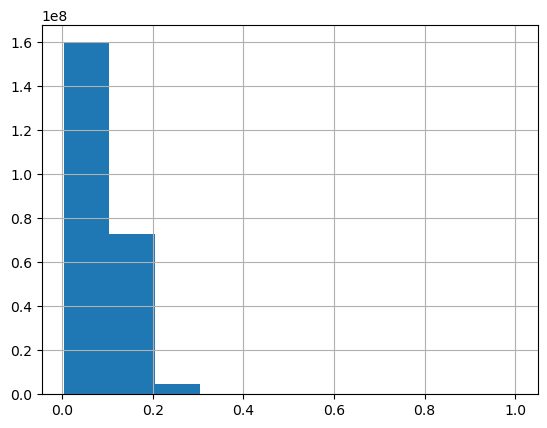

In [72]:
cosine_sim_long = cosine_sim_long[cosine_sim_long.Value > 0]
cosine_sim_long.Value.hist()

In [80]:
cosine_sim_long = cosine_sim_long.reset_index(drop =True)
cosine_sim_long

,i,Column,Value
0,0,1,0.089363
1,0,2,0.199036
2,1,2,0.155844
3,0,3,0.232076
4,1,3,0.075714
...,...,...,...
237733516,22114,22119,0.086242
237733517,22115,22119,0.088066
237733518,22116,22119,0.220319
237733519,22117,22119,0.259408


What happened so far:
- 22,120 patent-inventor pairs selected based on approriate strcount of description
- All zero values due to low similarity (dtm) dropped (0.13 billion)
- Picked only the upper triangle

In [88]:
cosine_sim_long

,i,j,Value,occ_i
0,0,1,0.089363,"HISCO410, HISCO744, HISCO896,"
1,0,2,0.199036,"HISCO410, HISCO744, HISCO896,"
2,1,2,0.155844,"HISCO779, HISCO951, HISCO813, HISCO896, HISCO3..."
3,0,3,0.232076,"HISCO410, HISCO744, HISCO896,"
4,1,3,0.075714,"HISCO779, HISCO951, HISCO813, HISCO896, HISCO3..."
...,...,...,...,...
237733516,22114,22119,0.086242,NA
237733517,22115,22119,0.088066,NA
237733518,22116,22119,0.220319,"HISCO333; HISCO999, HISCO999, HISCO33, HISCO333,"
237733519,22117,22119,0.259408,"HISCO333; HISCO999, HISCO999, HISCO33, HISCO333,"


In [91]:
# agg_occ = pd.read_feather('../final_data/agg_occ.feather')
agg_occ

,occupation_1,occupation_2,Combined_Value
0,HISCO410,HISCO744,0.166452
1,HISCO410,HISCO896,0.169314
2,HISCO410,HISCO779,0.150686
3,HISCO410,HISCO951,0.156130
4,HISCO410,HISCO813,0.169089
...,...,...,...
59775,HISCO395,HISCO755,0.219659
59776,HISCO395,HISCO641,0.190232
59777,HISCO395,HISCO772,0.102327
59778,HISCO395,HISCO815,0.178434


In [81]:
# # Merge data to get 'occhisco_i' and 'occhisco_j'
# cosine_sim_long = pd.merge(cosine_sim_long, data[['occupation.x']], left_on='i', right_index=True, how='left')
# cosine_sim_long = cosine_sim_long.rename(columns={'occupation.x': 'occ_i'})
# cosine_sim_long = pd.merge(cosine_sim_long, data[['occupation.x']], left_on='j', right_index=True, how='left')
# cosine_sim_long = cosine_sim_long.rename(columns={'occupation.x': 'occ_j'})
# print("merge done")

KeyError: 'j'

In [109]:
import pickle

with open('../int_data/cosine_sim_long.pkl','wb') as f:
     pickle.dump(cosine_sim_long, f)

In [ ]:
import pickle

with open('../int_data/cosine_sim_long.pkl','rb') as f:
    cosine_sim_long = pickle.load(f)

In [ ]:
cosine_sim_long.i.nunique(), cosine_sim_long.j.nunique(), cosine_sim_long.patent_id_i.nunique(), cosine_sim_long.patent_id_j.nunique()

In [ ]:
print_ram_usage()

In [37]:
# tab_i = dict(zip(cosine_sim_long['i'], cosine_sim_long['patent_id_i']))
# tab_j = dict(zip(cosine_sim_long['j'], cosine_sim_long['patent_id_j']))
tab_i == tab_j

In [ ]:
# import pickle

# with open('../int_data/cosine_sim_long.pkl','wb') as f:
#     pickle.dump(cosine_sim_long, f)

# New: Aggregate kw similarity by occupations
time complexity: O(n*n * m * m), where n is number of keywords, m is number of patents

### Create empty occ space

In [13]:
i_occ_mapping = data_explode_pre.reset_index()
i_occ_mapping.census_occupation[1] # many repeated occ strings in one census_occupation, e.g., 'HISCO745'

['HISCO779',
 'HISCO951',
 'HISCO813',
 'HISCO896',
 'HISCO391',
 'HISCO974',
 'HISCO745',
 'HISCO745',
 'HISCO779',
 'HISCO397',
 'HISCO974',
 'HISCO397']

In [14]:
i_occ_mapping.census_occupation = i_occ_mapping.census_occupation.apply(lambda x:list(set(x)))
i_occ_mapping

,index,i,census_occupation
0,0,GB187303416,"[HISCO744, HISCO410, HISCO896]"
1,1,GB187600824,"[HISCO974, HISCO779, HISCO745, HISCO896, HISCO..."
2,2,GB187601544,"[HISCO999, HISCO901, HISCO24, HISCO90, HISCO97..."
3,3,GB188204200,"[HISCO799, HISCO231, HISCO79, HISCO894, HISCO9..."
4,4,GB188803213,[HISCO777]
...,...,...,...
22115,22115,GB191211210,[NA]
22116,22116,GB191213037,"[HISCO999, HISCO333, HISCO33]"
22117,22117,GB191213039,"[HISCO999, HISCO333, HISCO33]"
22118,22118,GB191217939,"[HISCO999, HISCO333, HISCO33]"


In [15]:
i_occ_mapping.i.nunique() # does not correspond to 22,120 unique patent-inventor pairs


20742

- We choose index (which exactly matches "data" on shape[0]) to form the index:census_occupation mappings

In [16]:
# get all occs

i_occ_mapping['mapping'] = i_occ_mapping.apply(lambda x:{x['index']:x.census_occupation}, axis = 1)
combined_mapping = {}
i_occ_mapping['mapping'].apply(lambda x:combined_mapping.update(x))

combined_mapping

{0: ['HISCO744', 'HISCO410', 'HISCO896'],
 1: ['HISCO974',
  'HISCO779',
  'HISCO745',
  'HISCO896',
  'HISCO813',
  'HISCO391',
  'HISCO951',
  'HISCO397'],
 2: ['HISCO999', 'HISCO901', 'HISCO24', 'HISCO90', 'HISCO974', 'HISCO397'],
 3: ['HISCO799',
  'HISCO231',
  'HISCO79',
  'HISCO894',
  'HISCO931',
  'HISCO161',
  'HISCO391',
  'HISCO949',
  'HISCO221',
  'HISCO23',
  'HISCO22',
  'HISCO443'],
 4: ['HISCO777'],
 5: ['HISCO712', 'HISCO779', 'HISCO71', 'HISCO745'],
 6: ['HISCO24', 'HISCO33', 'HISCO331'],
 7: ['HISCO22'],
 8: ['HISCO22'],
 9: ['HISCO857'],
 10: ['HISCO981'],
 11: ['HISCO410', 'HISCO11', 'HISCO67'],
 12: ['HISCO999', 'HISCO333', 'HISCO33'],
 13: ['NA'],
 14: ['NA'],
 15: ['NA'],
 16: ['HISCO410', 'HISCO24', 'HISCO776'],
 17: ['HISCO754', 'HISCO79', 'HISCO24', 'HISCO75', 'HISCO799'],
 18: ['NA'],
 19: ['HISCO895', 'HISCO893'],
 20: ['NA'],
 21: ['NA'],
 22: ['NA'],
 23: ['NA'],
 24: ['HISCO942'],
 25: ['HISCO999', 'HISCO333', 'HISCO33', 'HISCO430'],
 26: ['HISCO999', 

In [17]:
len(combined_mapping)

22120

In [4]:
import pickle
with open('../int_data/combined_mapping.pkl','wb') as f:
    pickle.dump(combined_mapping, f)

NameError: name 'combined_mapping' is not defined

In [5]:
import pickle

with open('../int_data/combined_mapping.pkl','rb') as f:
    combined_mapping = pickle.load(f)

EOFError: Ran out of input

In [19]:
# create empty occ_space
all_occs = data_exploded.census_occupation.unique().tolist()
matrix_of_3_dim_empty_lists = [[[] for _ in all_occs] for _ in all_occs] # 245*245*1
occ_space = pd.DataFrame(matrix_of_3_dim_empty_lists, index=all_occs, columns=all_occs)

# Set the diagonal elements to 0
for i in all_occs:
    occ_space.at[i, i] = 0
occ_space

,HISCO410,HISCO744,HISCO896,HISCO779,HISCO951,HISCO813,HISCO391,HISCO974,HISCO745,HISCO397,...,HISCO922,HISCO961,HISCO972,HISCO452,HISCO755,HISCO641,HISCO772,HISCO815,HISCO902,HISCO395
HISCO410,0,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
HISCO744,[],0,[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
HISCO896,[],[],0,[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
HISCO779,[],[],[],0,[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
HISCO951,[],[],[],[],0,[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HISCO641,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],0,[],[],[],[]
HISCO772,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],0,[],[],[]
HISCO815,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],0,[],[]
HISCO902,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],0,[]


In [ ]:
import pickle
# with open('../int_data/occ_space_empty.pkl','wb') as f:
#     pickle.dump(occ_space, f)

In [6]:
import pickle

with open('../int_data/occ_space_empty.pkl','rb') as f:
    occ_space = pickle.load(f)

### Populate

In [13]:
print_ram_usage()

[0] RAM Usage: 9738.60 MB


In [14]:
import pickle

with open('../int_data/cosine_sim_long.pkl','rb') as f:
    cosine_sim_long = pickle.load(f)
cosine_sim_long

,i,j,Value
0,0,1,0.089363
1,0,2,0.199036
2,1,2,0.155844
3,0,3,0.232076
4,1,3,0.075714
...,...,...,...
237733516,22114,22119,0.086242
237733517,22115,22119,0.088066
237733518,22116,22119,0.220319
237733519,22117,22119,0.259408


In [15]:
cosine_sim_long.Value.value_counts()

Value
0.074536    61064
0.068041    56227
0.077152    55254
0.059761    55248
0.062994    53707
            ...  
0.252363        1
0.291609        1
0.104170        1
0.271742        1
0.303194        1
Name: count, Length: 1485579, dtype: int64

In [17]:

# populate_occ_space(cosine_sim_long.loc[0])
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import math

tqdm.pandas()
larger_index = occ_space.columns

def populate_occ_space(row):
    i = row['i']
    j = row['j']
    v = row['Value']

    index_i = [x for x in combined_mapping.get(i, []) if (x != 'NA' and x != np.nan)]
    index_j = [x for x in combined_mapping.get(j, []) if (x != 'NA' and x != np.nan)]

    overlap = set(index_i).intersection(set(index_j))

    index_i = [x for x in index_i if x not in overlap]
    index_j = [x for x in index_j if x not in overlap]

    temp_result = {}
    for ii in index_i:
        for jj in index_j:
            if (ii, jj) not in temp_result:
                temp_result[(ii, jj)] = []
            temp_result[(ii, jj)].append(v)
    return temp_result

def save_intermediate_results(df, filename, chunk_idx):
    df.to_pickle(filename)
    print(f"saved success! batch {chunk_idx}")

def process_chunk(args):
    df, chunk_idx, output_dir, batch_size = args
    print(f"Processing batch {chunk_idx}...")
    print(chunk_idx, chunk_idx+batch_size)
    chunk = df[chunk_idx: chunk_idx+batch_size]
    chunk_results = chunk.progress_apply(populate_occ_space, axis=1)
    
    combined_results = {}
    for result in chunk_results:
        for key, values in result.items():
            if key not in combined_results:
                combined_results[key] = []
            combined_results[key].extend(values)
    
    result_df = pd.DataFrame(index=larger_index, columns=larger_index)
    for (ii, jj), values in combined_results.items():
        result_df.at[ii, jj] = values
    # print(result_df)
    # Save intermediate result
    save_intermediate_results(result_df, os.path.join(output_dir, f"occ_space_chunk_{chunk_idx}_{chunk_idx+batch_size}.pkl"), chunk_idx)

def run_parallel_processing(df, output_dir, batch_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Determine starting index by checking existing files in the output directory
    existing_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
    start_idx = max([int(f.split('_')[-1].split('.')[0]) for f in existing_files], default=0)
    print(start_idx)
    
        
    # chunks = [df[i:i + batch_size] for i in range(0, len(df), batch_size)]
    for i in range(start_idx, len(df), batch_size):
        process_chunk((cosine_sim_long, i, output_dir, batch_size))

# def process_chunk(args):
#     df, chunk_idx, output_dir, batch_size = args
#     print(f"Processing batch {chunk_idx}...")
#     chunk = df[chunk_idx: chunk_idx+batch_size]
#     chunk_results = chunk.progress_apply(populate_occ_space, axis=1)
    
#     combined_results = {}
#     for result in chunk_results:
#         for key, values in result.items():
#             if key not in combined_results:
#                 combined_results[key] = []
#             combined_results[key].extend(values)
    
#     result_df = pd.DataFrame(index=larger_index, columns=larger_index)
#     for (ii, jj), values in combined_results.items():
#         result_df.at[ii, jj] = values

#     # Save intermediate result
#     save_intermediate_results(result_df, os.path.join(output_dir, f"occ_space_chunk_{chunk_idx}_{chunk_idx+batch_size}.pkl"), chunk_idx)

# def run_parallel_processing(df, output_dir, batch_size):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # Determine starting index by checking existing files in the output directory
#     existing_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
#     start_idx = max([int(f.split('_')[-1].split('.')[0]) for f in existing_files], default=0)
#     print(f"Starting from index: {start_idx}")

#     # Prepare arguments for each chunk
#     chunks = [(df, i, output_dir, batch_size) for i in range(start_idx, len(df), batch_size)]
    
#     # Process chunks in parallel
#     with Pool(cpu_count()-2) as pool:
#         pool.map(process_chunk, chunks)
        
output_dir = "../int_data/occ_space_chunks"
# Run parallel processing and save intermediate results
batch_size = 200000  # Customize batch size as needed
run_parallel_processing(cosine_sim_long, "../int_data/occ_space_chunks", batch_size)


211400000
Processing batch 211400000...
211400000 211600000


100%|██████████| 200000/200000 [00:20<00:00, 9712.56it/s] 


saved success! batch 211400000
Processing batch 211600000...
211600000 211800000


100%|██████████| 200000/200000 [00:21<00:00, 9500.85it/s] 


saved success! batch 211600000
Processing batch 211800000...
211800000 212000000


100%|██████████| 200000/200000 [00:21<00:00, 9366.68it/s] 


saved success! batch 211800000
Processing batch 212000000...
212000000 212200000


100%|██████████| 200000/200000 [00:19<00:00, 10141.22it/s]


saved success! batch 212000000
Processing batch 212200000...
212200000 212400000


100%|██████████| 200000/200000 [00:21<00:00, 9182.95it/s] 


saved success! batch 212200000
Processing batch 212400000...
212400000 212600000


100%|██████████| 200000/200000 [00:20<00:00, 9873.29it/s] 


saved success! batch 212400000
Processing batch 212600000...
212600000 212800000


100%|██████████| 200000/200000 [00:20<00:00, 9863.53it/s] 


saved success! batch 212600000
Processing batch 212800000...
212800000 213000000


100%|██████████| 200000/200000 [00:20<00:00, 9911.36it/s] 


saved success! batch 212800000
Processing batch 213000000...
213000000 213200000


100%|██████████| 200000/200000 [00:20<00:00, 9804.71it/s] 


saved success! batch 213000000
Processing batch 213200000...
213200000 213400000


100%|██████████| 200000/200000 [00:19<00:00, 10139.73it/s]


saved success! batch 213200000
Processing batch 213400000...
213400000 213600000


100%|██████████| 200000/200000 [00:21<00:00, 9290.25it/s] 


saved success! batch 213400000
Processing batch 213600000...
213600000 213800000


100%|██████████| 200000/200000 [00:20<00:00, 9712.08it/s] 


saved success! batch 213600000
Processing batch 213800000...
213800000 214000000


100%|██████████| 200000/200000 [00:22<00:00, 8801.53it/s] 


saved success! batch 213800000
Processing batch 214000000...
214000000 214200000


100%|██████████| 200000/200000 [00:20<00:00, 9816.78it/s] 


saved success! batch 214000000
Processing batch 214200000...
214200000 214400000


100%|██████████| 200000/200000 [00:22<00:00, 9078.23it/s] 


saved success! batch 214200000
Processing batch 214400000...
214400000 214600000


100%|██████████| 200000/200000 [00:21<00:00, 9434.67it/s] 


saved success! batch 214400000
Processing batch 214600000...
214600000 214800000


100%|██████████| 200000/200000 [00:19<00:00, 10086.08it/s]


saved success! batch 214600000
Processing batch 214800000...
214800000 215000000


100%|██████████| 200000/200000 [00:20<00:00, 9707.17it/s] 


saved success! batch 214800000
Processing batch 215000000...
215000000 215200000


100%|██████████| 200000/200000 [00:21<00:00, 9476.15it/s] 


saved success! batch 215000000
Processing batch 215200000...
215200000 215400000


100%|██████████| 200000/200000 [00:20<00:00, 9749.47it/s] 


saved success! batch 215200000
Processing batch 215400000...
215400000 215600000


100%|██████████| 200000/200000 [00:21<00:00, 9371.69it/s] 


saved success! batch 215400000
Processing batch 215600000...
215600000 215800000


100%|██████████| 200000/200000 [00:20<00:00, 9890.72it/s] 


saved success! batch 215600000
Processing batch 215800000...
215800000 216000000


100%|██████████| 200000/200000 [00:19<00:00, 10167.76it/s]


saved success! batch 215800000
Processing batch 216000000...
216000000 216200000


100%|██████████| 200000/200000 [00:19<00:00, 10069.14it/s]


saved success! batch 216000000
Processing batch 216200000...
216200000 216400000


100%|██████████| 200000/200000 [00:20<00:00, 9780.97it/s] 


saved success! batch 216200000
Processing batch 216400000...
216400000 216600000


100%|██████████| 200000/200000 [00:20<00:00, 9662.69it/s] 


saved success! batch 216400000
Processing batch 216600000...
216600000 216800000


100%|██████████| 200000/200000 [00:20<00:00, 9811.64it/s] 


saved success! batch 216600000
Processing batch 216800000...
216800000 217000000


100%|██████████| 200000/200000 [00:21<00:00, 9298.91it/s] 


saved success! batch 216800000
Processing batch 217000000...
217000000 217200000


100%|██████████| 200000/200000 [00:20<00:00, 9715.49it/s] 


saved success! batch 217000000
Processing batch 217200000...
217200000 217400000


100%|██████████| 200000/200000 [00:21<00:00, 9455.78it/s] 


saved success! batch 217200000
Processing batch 217400000...
217400000 217600000


100%|██████████| 200000/200000 [00:20<00:00, 9996.07it/s] 


saved success! batch 217400000
Processing batch 217600000...
217600000 217800000


100%|██████████| 200000/200000 [00:21<00:00, 9473.12it/s] 


saved success! batch 217600000
Processing batch 217800000...
217800000 218000000


100%|██████████| 200000/200000 [00:20<00:00, 9982.90it/s] 


saved success! batch 217800000
Processing batch 218000000...
218000000 218200000


100%|██████████| 200000/200000 [00:20<00:00, 9719.47it/s] 


saved success! batch 218000000
Processing batch 218200000...
218200000 218400000


100%|██████████| 200000/200000 [00:20<00:00, 9961.75it/s] 


saved success! batch 218200000
Processing batch 218400000...
218400000 218600000


100%|██████████| 200000/200000 [00:20<00:00, 9839.76it/s] 


saved success! batch 218400000
Processing batch 218600000...
218600000 218800000


100%|██████████| 200000/200000 [00:20<00:00, 9825.61it/s] 


saved success! batch 218600000
Processing batch 218800000...
218800000 219000000


100%|██████████| 200000/200000 [00:20<00:00, 9640.10it/s] 


saved success! batch 218800000
Processing batch 219000000...
219000000 219200000


100%|██████████| 200000/200000 [00:20<00:00, 9589.25it/s] 


saved success! batch 219000000
Processing batch 219200000...
219200000 219400000


100%|██████████| 200000/200000 [00:20<00:00, 9803.76it/s] 


saved success! batch 219200000
Processing batch 219400000...
219400000 219600000


100%|██████████| 200000/200000 [00:19<00:00, 10014.49it/s]


saved success! batch 219400000
Processing batch 219600000...
219600000 219800000


100%|██████████| 200000/200000 [00:20<00:00, 9628.70it/s] 


saved success! batch 219600000
Processing batch 219800000...
219800000 220000000


100%|██████████| 200000/200000 [00:20<00:00, 9769.96it/s] 


saved success! batch 219800000
Processing batch 220000000...
220000000 220200000


100%|██████████| 200000/200000 [00:20<00:00, 9730.21it/s] 


saved success! batch 220000000
Processing batch 220200000...
220200000 220400000


100%|██████████| 200000/200000 [00:20<00:00, 9945.10it/s] 


saved success! batch 220200000
Processing batch 220400000...
220400000 220600000


100%|██████████| 200000/200000 [00:20<00:00, 9894.42it/s] 


saved success! batch 220400000
Processing batch 220600000...
220600000 220800000


100%|██████████| 200000/200000 [00:20<00:00, 9919.54it/s] 


saved success! batch 220600000
Processing batch 220800000...
220800000 221000000


100%|██████████| 200000/200000 [00:20<00:00, 9583.34it/s] 


saved success! batch 220800000
Processing batch 221000000...
221000000 221200000


100%|██████████| 200000/200000 [00:19<00:00, 10033.60it/s]


saved success! batch 221000000
Processing batch 221200000...
221200000 221400000


100%|██████████| 200000/200000 [00:20<00:00, 9856.97it/s] 


saved success! batch 221200000
Processing batch 221400000...
221400000 221600000


100%|██████████| 200000/200000 [00:20<00:00, 9537.25it/s] 


saved success! batch 221400000
Processing batch 221600000...
221600000 221800000


100%|██████████| 200000/200000 [00:20<00:00, 9667.39it/s] 


saved success! batch 221600000
Processing batch 221800000...
221800000 222000000


100%|██████████| 200000/200000 [00:20<00:00, 9655.31it/s] 


saved success! batch 221800000
Processing batch 222000000...
222000000 222200000


100%|██████████| 200000/200000 [00:21<00:00, 9477.14it/s] 


saved success! batch 222000000
Processing batch 222200000...
222200000 222400000


100%|██████████| 200000/200000 [00:20<00:00, 9838.42it/s] 


saved success! batch 222200000
Processing batch 222400000...
222400000 222600000


100%|██████████| 200000/200000 [00:21<00:00, 9166.51it/s] 


saved success! batch 222400000
Processing batch 222600000...
222600000 222800000


100%|██████████| 200000/200000 [00:22<00:00, 8708.39it/s] 


saved success! batch 222600000
Processing batch 222800000...
222800000 223000000


100%|██████████| 200000/200000 [00:20<00:00, 9671.77it/s] 


saved success! batch 222800000
Processing batch 223000000...
223000000 223200000


100%|██████████| 200000/200000 [00:21<00:00, 9400.04it/s] 


saved success! batch 223000000
Processing batch 223200000...
223200000 223400000


100%|██████████| 200000/200000 [00:19<00:00, 10257.77it/s]


saved success! batch 223200000
Processing batch 223400000...
223400000 223600000


100%|██████████| 200000/200000 [00:22<00:00, 8982.58it/s] 


saved success! batch 223400000
Processing batch 223600000...
223600000 223800000


100%|██████████| 200000/200000 [00:20<00:00, 9981.93it/s] 


saved success! batch 223600000
Processing batch 223800000...
223800000 224000000


100%|██████████| 200000/200000 [00:20<00:00, 9648.51it/s] 


saved success! batch 223800000
Processing batch 224000000...
224000000 224200000


100%|██████████| 200000/200000 [00:20<00:00, 9903.15it/s] 


saved success! batch 224000000
Processing batch 224200000...
224200000 224400000


100%|██████████| 200000/200000 [00:20<00:00, 9606.69it/s] 


saved success! batch 224200000
Processing batch 224400000...
224400000 224600000


100%|██████████| 200000/200000 [00:20<00:00, 9650.90it/s] 


saved success! batch 224400000
Processing batch 224600000...
224600000 224800000


100%|██████████| 200000/200000 [00:20<00:00, 9893.13it/s] 


saved success! batch 224600000
Processing batch 224800000...
224800000 225000000


100%|██████████| 200000/200000 [00:20<00:00, 9955.89it/s] 


saved success! batch 224800000
Processing batch 225000000...
225000000 225200000


100%|██████████| 200000/200000 [00:20<00:00, 9598.07it/s] 


saved success! batch 225000000
Processing batch 225200000...
225200000 225400000


100%|██████████| 200000/200000 [00:20<00:00, 9966.68it/s] 


saved success! batch 225200000
Processing batch 225400000...
225400000 225600000


100%|██████████| 200000/200000 [00:20<00:00, 9528.93it/s] 


saved success! batch 225400000
Processing batch 225600000...
225600000 225800000


100%|██████████| 200000/200000 [00:20<00:00, 9864.11it/s] 


saved success! batch 225600000
Processing batch 225800000...
225800000 226000000


100%|██████████| 200000/200000 [00:20<00:00, 9973.03it/s] 


saved success! batch 225800000
Processing batch 226000000...
226000000 226200000


100%|██████████| 200000/200000 [00:20<00:00, 9614.00it/s] 


saved success! batch 226000000
Processing batch 226200000...
226200000 226400000


100%|██████████| 200000/200000 [00:21<00:00, 9442.49it/s] 


saved success! batch 226200000
Processing batch 226400000...
226400000 226600000


100%|██████████| 200000/200000 [00:21<00:00, 9380.93it/s] 


saved success! batch 226400000
Processing batch 226600000...
226600000 226800000


100%|██████████| 200000/200000 [00:20<00:00, 9603.57it/s] 


saved success! batch 226600000
Processing batch 226800000...
226800000 227000000


100%|██████████| 200000/200000 [00:20<00:00, 9524.09it/s] 


saved success! batch 226800000
Processing batch 227000000...
227000000 227200000


100%|██████████| 200000/200000 [00:20<00:00, 9573.60it/s] 


saved success! batch 227000000
Processing batch 227200000...
227200000 227400000


100%|██████████| 200000/200000 [00:20<00:00, 9695.31it/s] 


saved success! batch 227200000
Processing batch 227400000...
227400000 227600000


100%|██████████| 200000/200000 [00:21<00:00, 9520.73it/s] 


saved success! batch 227400000
Processing batch 227600000...
227600000 227800000


100%|██████████| 200000/200000 [00:20<00:00, 9873.39it/s] 


saved success! batch 227600000
Processing batch 227800000...
227800000 228000000


100%|██████████| 200000/200000 [00:19<00:00, 10030.70it/s]


saved success! batch 227800000
Processing batch 228000000...
228000000 228200000


100%|██████████| 200000/200000 [00:21<00:00, 9450.88it/s] 


saved success! batch 228000000
Processing batch 228200000...
228200000 228400000


100%|██████████| 200000/200000 [00:21<00:00, 9393.62it/s] 


saved success! batch 228200000
Processing batch 228400000...
228400000 228600000


100%|██████████| 200000/200000 [00:20<00:00, 9706.95it/s] 


saved success! batch 228400000
Processing batch 228600000...
228600000 228800000


100%|██████████| 200000/200000 [00:20<00:00, 9810.50it/s] 


saved success! batch 228600000
Processing batch 228800000...
228800000 229000000


100%|██████████| 200000/200000 [00:21<00:00, 9434.71it/s] 


saved success! batch 228800000
Processing batch 229000000...
229000000 229200000


100%|██████████| 200000/200000 [00:20<00:00, 9957.73it/s] 


saved success! batch 229000000
Processing batch 229200000...
229200000 229400000


100%|██████████| 200000/200000 [00:21<00:00, 9491.16it/s] 


saved success! batch 229200000
Processing batch 229400000...
229400000 229600000


100%|██████████| 200000/200000 [00:20<00:00, 9685.73it/s] 


saved success! batch 229400000
Processing batch 229600000...
229600000 229800000


100%|██████████| 200000/200000 [00:20<00:00, 9694.73it/s] 


saved success! batch 229600000
Processing batch 229800000...
229800000 230000000


100%|██████████| 200000/200000 [00:19<00:00, 10116.26it/s]


saved success! batch 229800000
Processing batch 230000000...
230000000 230200000


100%|██████████| 200000/200000 [00:19<00:00, 10040.50it/s]


saved success! batch 230000000
Processing batch 230200000...
230200000 230400000


100%|██████████| 200000/200000 [00:20<00:00, 9690.64it/s] 


saved success! batch 230200000
Processing batch 230400000...
230400000 230600000


100%|██████████| 200000/200000 [00:19<00:00, 10021.56it/s]


saved success! batch 230400000
Processing batch 230600000...
230600000 230800000


100%|██████████| 200000/200000 [00:20<00:00, 9727.57it/s] 


saved success! batch 230600000
Processing batch 230800000...
230800000 231000000


100%|██████████| 200000/200000 [00:20<00:00, 9868.17it/s] 


saved success! batch 230800000
Processing batch 231000000...
231000000 231200000


100%|██████████| 200000/200000 [00:20<00:00, 9658.22it/s] 


saved success! batch 231000000
Processing batch 231200000...
231200000 231400000


100%|██████████| 200000/200000 [00:20<00:00, 9957.64it/s] 


saved success! batch 231200000
Processing batch 231400000...
231400000 231600000


100%|██████████| 200000/200000 [00:21<00:00, 9441.34it/s] 


saved success! batch 231400000
Processing batch 231600000...
231600000 231800000


100%|██████████| 200000/200000 [00:20<00:00, 9860.81it/s] 


saved success! batch 231600000
Processing batch 231800000...
231800000 232000000


100%|██████████| 200000/200000 [00:20<00:00, 9688.90it/s] 


saved success! batch 231800000
Processing batch 232000000...
232000000 232200000


100%|██████████| 200000/200000 [00:21<00:00, 9387.42it/s] 


saved success! batch 232000000
Processing batch 232200000...
232200000 232400000


100%|██████████| 200000/200000 [00:20<00:00, 9941.50it/s] 


saved success! batch 232200000
Processing batch 232400000...
232400000 232600000


100%|██████████| 200000/200000 [00:20<00:00, 9595.10it/s] 


saved success! batch 232400000
Processing batch 232600000...
232600000 232800000


100%|██████████| 200000/200000 [00:21<00:00, 9521.14it/s] 


saved success! batch 232600000
Processing batch 232800000...
232800000 233000000


100%|██████████| 200000/200000 [00:20<00:00, 9697.61it/s] 


saved success! batch 232800000
Processing batch 233000000...
233000000 233200000


100%|██████████| 200000/200000 [00:20<00:00, 9789.84it/s] 


saved success! batch 233000000
Processing batch 233200000...
233200000 233400000


100%|██████████| 200000/200000 [00:20<00:00, 9675.71it/s] 


saved success! batch 233200000
Processing batch 233400000...
233400000 233600000


100%|██████████| 200000/200000 [00:20<00:00, 9841.18it/s] 


saved success! batch 233400000
Processing batch 233600000...
233600000 233800000


100%|██████████| 200000/200000 [00:21<00:00, 9445.84it/s] 


saved success! batch 233600000
Processing batch 233800000...
233800000 234000000


100%|██████████| 200000/200000 [00:20<00:00, 9634.64it/s] 


saved success! batch 233800000
Processing batch 234000000...
234000000 234200000


100%|██████████| 200000/200000 [00:20<00:00, 9966.13it/s] 


saved success! batch 234000000
Processing batch 234200000...
234200000 234400000


100%|██████████| 200000/200000 [00:20<00:00, 9711.51it/s] 


saved success! batch 234200000
Processing batch 234400000...
234400000 234600000


100%|██████████| 200000/200000 [00:21<00:00, 9490.46it/s] 


saved success! batch 234400000
Processing batch 234600000...
234600000 234800000


100%|██████████| 200000/200000 [00:20<00:00, 9981.75it/s] 


saved success! batch 234600000
Processing batch 234800000...
234800000 235000000


100%|██████████| 200000/200000 [00:20<00:00, 9893.29it/s] 


saved success! batch 234800000
Processing batch 235000000...
235000000 235200000


100%|██████████| 200000/200000 [00:20<00:00, 9587.28it/s] 


saved success! batch 235000000
Processing batch 235200000...
235200000 235400000


100%|██████████| 200000/200000 [00:19<00:00, 10119.42it/s]


saved success! batch 235200000
Processing batch 235400000...
235400000 235600000


100%|██████████| 200000/200000 [00:20<00:00, 9599.32it/s] 


saved success! batch 235400000
Processing batch 235600000...
235600000 235800000


100%|██████████| 200000/200000 [00:20<00:00, 9881.87it/s] 


saved success! batch 235600000
Processing batch 235800000...
235800000 236000000


100%|██████████| 200000/200000 [00:20<00:00, 9909.96it/s] 


saved success! batch 235800000
Processing batch 236000000...
236000000 236200000


100%|██████████| 200000/200000 [00:22<00:00, 9013.53it/s] 


saved success! batch 236000000
Processing batch 236200000...
236200000 236400000


100%|██████████| 200000/200000 [00:21<00:00, 9429.99it/s] 


saved success! batch 236200000
Processing batch 236400000...
236400000 236600000


100%|██████████| 200000/200000 [00:20<00:00, 9836.11it/s] 


saved success! batch 236400000
Processing batch 236600000...
236600000 236800000


100%|██████████| 200000/200000 [00:20<00:00, 9549.62it/s] 


saved success! batch 236600000
Processing batch 236800000...
236800000 237000000


100%|██████████| 200000/200000 [00:20<00:00, 9656.00it/s] 


saved success! batch 236800000
Processing batch 237000000...
237000000 237200000


100%|██████████| 200000/200000 [00:20<00:00, 9859.29it/s] 


saved success! batch 237000000
Processing batch 237200000...
237200000 237400000


100%|██████████| 200000/200000 [00:22<00:00, 8932.82it/s] 


saved success! batch 237200000
Processing batch 237400000...
237400000 237600000


100%|██████████| 200000/200000 [00:20<00:00, 9548.98it/s] 


saved success! batch 237400000
Processing batch 237600000...
237600000 237800000


100%|██████████| 133521/133521 [00:11<00:00, 11284.33it/s]


saved success! batch 237600000


In [ ]:
start_idx = 211400000 
chunks = [(cosine_sim_long, i, output_dir, batch_size) for i in range(start_idx, len(cosine_sim_long), batch_size)]
print_ram_usage()
# Process chunks in parallel
with Pool(2) as pool:
    pool.map(process_chunk, chunks)

[0] RAM Usage: 23393.35 MB


In [59]:
# run_parallel_processing(cosine_sim_long, "../int_data/occ_space_chunks", batch_size)
process_chunk((cosine_sim_long, 0, output_dir, batch_size))

Processing batch 0...
0 200000


100%|██████████| 200000/200000 [00:21<00:00, 9493.19it/s] 


saved success! batch 0


In [60]:
gc.collect()
print_ram_usage(), cpu_count()

[0] RAM Usage: 34111.42 MB


(None, 32)

In [ ]:
import pickle
with open('../int_data/occ_space_populated.pkl','wb') as f:
    pickle.dump(cosine_sim_long,f)

In [5]:
import pickle

with open('../int_data/occ_space.pkl','rb') as f:
    occ_space_populated = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../int_data/occ_space.pkl'

In [ ]:
# 
occ_space_populated = occ_space_populated.applymap(lambda x: np.mean(x) if x else 0)


### Concatenate

In [19]:
import os
import pandas as pd
import numpy as np

# Assuming larger_index is already defined
larger_index = occ_space.columns

def read_intermediate_results(directory):
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pkl')]
    dataframes = [pd.read_pickle(file) for file in all_files]
    return dataframes

def combine_results(dataframes, larger_index):
    final_matrix = pd.DataFrame([[[] for _ in range(len(larger_index))] for _ in range(len(larger_index))],
                                index=larger_index, columns=larger_index)
    
    for df in dataframes:
        for i in df.index:
            for j in df.columns:
                if isinstance(df.at[i, j], list):
                    final_matrix.at[i, j].extend(df.at[i, j])
                    final_matrix.at[j, i].extend(df.at[i, j])
    # TO-DO: cuurent time complexity O(N * N), could reduce to (N * N /2) by storing visited indexes and columns and populating only the upper triangle
    
    return final_matrix

def compute_mean_matrix(final_matrix):
    mean_matrix = final_matrix.applymap(lambda x: np.mean(x) if x else 0)
    return mean_matrix

def post_process_mean_matrix(mean_matrix):
    # Eliminate lower triangle
    for i in range(mean_matrix.shape[0]):
        for j in range(i + 1, mean_matrix.shape[1]):
            mean_matrix.iat[j, i] = 0
    
    return mean_matrix

def melt_to_long_table(matrix):
    long_table = matrix.reset_index().melt(id_vars=['index'], var_name='Column', value_name='Value')
    long_table = long_table[long_table['Value'] != 0].reset_index(drop = True).rename(columns = {'index': 'occ_i', 'Column':'occ_j'})  # Remove zero values if necessary
    return long_table

# Read the intermediate results
# dataframes = read_intermediate_results("../int_data/occ_space_chunks")

# # Combine the results into the final matrix
# final_matrix = combine_results(dataframes, larger_index)

# # Compute the mean matrix
# mean_matrix = compute_mean_matrix(final_matrix)

# # Post-process to eliminate the lower triangle
# mean_matrix = post_process_mean_matrix(mean_matrix)

# Optional: Melt to long table
long_table = melt_to_long_table(mean_matrix)

# Print to verify the mean matrix
print(mean_matrix)

# Print to verify the long table
long_table


          HISCO410  HISCO744  HISCO896  HISCO779  HISCO951  HISCO813  \
HISCO410       0.0  0.087692  0.080716  0.071001  0.080445  0.088636   
HISCO744       0.0  0.000000  0.093546  0.079812  0.089370  0.096322   
HISCO896       0.0  0.000000  0.000000  0.077624  0.082793  0.088782   
HISCO779       0.0  0.000000  0.000000  0.000000  0.073686  0.073348   
HISCO951       0.0  0.000000  0.000000  0.000000  0.000000  0.093294   
...            ...       ...       ...       ...       ...       ...   
HISCO641       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
HISCO772       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
HISCO815       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
HISCO902       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
HISCO395       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

          HISCO391  HISCO974  HISCO745  HISCO397  ...  HISCO922  HISCO961  \
HISCO410  0.088448  0.081975  0.059460  0.081573  ...  0.1

,occ_i,occ_j,Value
0,HISCO410,HISCO744,0.087692
1,HISCO410,HISCO896,0.080716
2,HISCO744,HISCO896,0.093546
3,HISCO410,HISCO779,0.071001
4,HISCO744,HISCO779,0.079812
...,...,...,...
29672,HISCO755,HISCO395,0.134695
29673,HISCO641,HISCO395,0.130270
29674,HISCO772,HISCO395,0.135554
29675,HISCO815,HISCO395,0.069130


In [27]:
# mean_matrix.to_csv('../final_data/mean_matrix_245_245.csv', index = False)
# long_table.to_csv('../final_data/long_table_29677.csv', index = False)

In [24]:
# Check if the matrix is upper triangular
is_upper_triangular = np.allclose(mean_matrix.values, np.triu(mean_matrix.values))

# Print the result
print("Is the matrix upper triangular?", is_upper_triangular)
mean_matrix
# unique values and distribution
long_table.occ_i.nunique(), long_table.occ_j.nunique(), long_table.Value.hist(bins = 100)

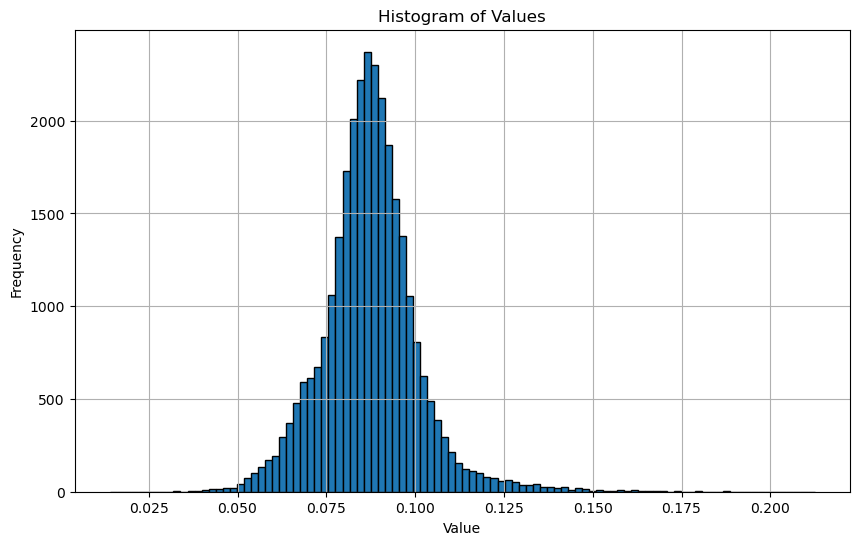

Unique occ_i: 244
Unique occ_j: 244
Histogram saved as value_histogram.png


In [28]:
# .save("../figs_tabs/value_dist.png")
import pandas as pd
import matplotlib.pyplot as plt

# Assuming long_table is your DataFrame
# Compute the unique counts
occ_i_unique = long_table.occ_i.nunique()
occ_j_unique = long_table.occ_j.nunique()

# Plot and save the histogram for Value column
plt.figure(figsize=(10, 6))
plt.hist(long_table['Value'], bins=100, edgecolor='k')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
plt.savefig('../figs_tabs/value_dist.png')
plt.close()


print(f"Unique occ_i: {occ_i_unique}")
print(f"Unique occ_j: {occ_j_unique}")
print("Histogram saved as value_histogram.png")


In [10]:
!ls -lha ../int_data/occ_space_chunks/occ_space_chunk* | wc -l

1189


# Start (depcrecated)

In [27]:
# %%time
# # 14.1 s for 2000 * 2000
# import numpy as np
# import pandas as pd

# # Number of unique i and j indices
# n = 20000

# # Generate random similarity values for the full matrix
# values = np.random.rand(n, n)

# # Create a DataFrame with all (i, j) pairs
# data = {
#     'i': np.repeat(np.arange(n), n),
#     'j': np.tile(np.arange(n), n),
#     'Value': values.flatten(),
#     'patent_id_i': [f'GB{np.random.randint(100000000, 999999999)}' for _ in range(n*n)],
#     'patent_id_j': [f'GB{np.random.randint(100000000, 999999999)}' for _ in range(n*n)]
# }

# df = pd.DataFrame(data)


KeyboardInterrupt: 

In [18]:
# %%time
# # Convert to NumPy array
# cosine_sim_long = df[['i', 'j', 'Value']].to_numpy()

NameError: name 'df' is not defined

In [19]:
%%time
# Convert to NumPy array
cosine_sim_long = cosine_sim_long[['i', 'j', 'Value']].to_numpy()

CPU times: user 18.9 s, sys: 18.1 s, total: 37 s
Wall time: 36.9 s


In [20]:
%%time

# Get the upper triangle (i < j)
upper = cosine_sim_long[cosine_sim_long[:, 0] < cosine_sim_long[:, 1]]

# Get the lower triangle (i > j)
lower = cosine_sim_long[cosine_sim_long[:, 0] > cosine_sim_long[:, 1]]

# Flip i and j in the lower triangle
lower_flipped = lower.copy()
lower_flipped[:, [0, 1]] = lower_flipped[:, [1, 0]]
print_ram_usage()

[0] RAM Usage: 97111.00 MB
CPU times: user 22.3 s, sys: 9.39 s, total: 31.7 s
Wall time: 31.7 s


In [21]:
%%time
# Combine the triangles
combined = np.concatenate((upper, lower_flipped), axis=0)

# Sum the values of the combined triangles by (i, j)
# Create a DataFrame for easier aggregation
combined_df = pd.DataFrame(combined, columns=['i', 'j', 'Value'])
print_ram_usage()


[0] RAM Usage: 108309.55 MB
CPU times: user 4.22 s, sys: 5.54 s, total: 9.77 s
Wall time: 9.73 s


In [22]:
upper.shape, lower.shape

((244636140, 3), (244636140, 3))

In [23]:
%%time

# Group by (i, j) and sum the 'Value' column
result_df = combined_df.groupby(['i', 'j'], as_index=False).sum()
print_ram_usage()
result_df

[0] RAM Usage: 121435.66 MB
CPU times: user 3min 33s, sys: 24.2 s, total: 3min 57s
Wall time: 3min 57s


,i,j,Value
0,0,1,0.178727
1,0,2,0.398073
2,0,3,0.464152
3,0,4,0.103452
4,0,5,0.045775
...,...,...,...
244636135,22116,22118,0.389079
244636136,22116,22119,0.440638
244636137,22117,22118,0.452911
244636138,22117,22119,0.518816


In [24]:
print_ram_usage()


[0] RAM Usage: 121435.66 MB


In [25]:
# Combine the triangles
combined = np.vstack((upper, lower_flipped))

# Using NumPy to sum values for (i, j) pairs efficiently
ij = combined[:, :2].astype(int)
values = combined[:, 2]

# Create an empty matrix for the summed values
summed_values = np.zeros((n, n))

# Sum the values into the matrix
for k in range(combined.shape[0]):
    i, j = ij[k]
    summed_values[i, j] += values[k]

# Convert the matrix to a DataFrame if needed
result_df = pd.DataFrame(summed_values)

# Display the result
print(result_df)

NameError: name 'n' is not defined

In [ ]:
# import pickle

# with open('../int_data/result_df.pkl','wb') as f:
#     pickle.dump(result_df, f)

In [ ]:
import pickle

with open('../int_data/result_df.pkl','rb') as f:
    result_df = pickle.load(f)

In [26]:
result_df

,i,j,Value
0,0,1,0.178727
1,0,2,0.398073
2,0,3,0.464152
3,0,4,0.103452
4,0,5,0.045775
...,...,...,...
244636135,22116,22118,0.389079
244636136,22116,22119,0.440638
244636137,22117,22118,0.452911
244636138,22117,22119,0.518816


In [9]:
%%time
print_ram_usage()

result_df['patent_id_i'] = result_df['i'].apply(lambda x:tab_i[x])
print_ram_usage()

result_df['patent_id_j'] = result_df['j'].apply(lambda x:tab_j[x])
print_ram_usage()

# result_df = pd.merge(left = result_df, right = cosine_sim_long[['j', 'patent_id_j']], left_on = 'j', right_on = 'j')

[0] RAM Usage: 11325.62 MB



KeyboardInterrupt



In [47]:
result_df.dtypes, type(result_df.Value.iloc[0])

(i              object
 j              object
 Value          object
 patent_id_i    object
 patent_id_j    object
 dtype: object,
 float)

In [51]:
result_df.patent_id_i.isnull().sum(), result_df.patent_id_j.isnull().sum()

(0, 0)

In [48]:
# result_df.to_csv('../final_data/result_22120.csv', index = False)

# Aggregation on occupation

In [2]:
import pandas as pd
# result_df = pd.read_csv('../final_data/result_22120.csv')
result_df = pd.read_feather('../final_data/result_22120.feather')

In [3]:
result_df

,i,j,Value,patent_id_i,patent_id_j
0,0,1,0.178727,GB187303416,GB187600824
1,0,2,0.398073,GB187303416,GB187601544
2,0,3,0.464152,GB187303416,GB188204200
3,0,4,0.103452,GB187303416,GB188803213
4,0,5,0.045775,GB187303416,GB188905132
...,...,...,...,...,...
244636135,22116,22118,0.389079,GB191213037,GB191217939
244636136,22116,22119,0.440638,GB191213037,GB191220302
244636137,22117,22118,0.452911,GB191213039,GB191217939
244636138,22117,22119,0.518816,GB191213039,GB191220302


## Exploding Input_patent_matrix to get OCC_SPACE (unique non-na occs)

In [4]:
data = pd.read_csv('../int_data/Input_patent_matrix.csv')
data['strcount'] = data['description'].str.split().str.len()
# Filter the data based on the word count
# Too long or too short patents are filtered
data = data[(data['strcount'] > 10) & (data['strcount'] <= 500)].reset_index(drop = True)
data = data[['i', 'occupation.x']].rename(columns = {"occupation.x":"census_occupation"})

# str -> list
data_explode_pre = data
import re
# To split a string by both ", " and "; "

data_explode_pre.census_occupation = data_explode_pre.census_occupation.apply(lambda x: re.split(r', |; ', x.strip().strip(',')))
# data_explode_pre.census_occupation = data_explode_pre.census_occupation.apply(lambda x:x.strip().strip(',').split(', '))

In [5]:
data_explode_pre

,i,census_occupation
0,GB187303416,"[HISCO410, HISCO744, HISCO896]"
1,GB187600824,"[HISCO779, HISCO951, HISCO813, HISCO896, HISCO..."
2,GB187601544,"[HISCO999, HISCO974, HISCO90, HISCO24, HISCO90..."
3,GB188204200,"[HISCO949, HISCO443, HISCO161, HISCO799, HISCO..."
4,GB188803213,[HISCO777]
...,...,...
22115,GB191211210,[NA]
22116,GB191213037,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"
22117,GB191213039,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"
22118,GB191217939,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"


In [6]:
data_explode_pre.census_occupation[0][0]

'HISCO410'

In [7]:
data_exploded = data_explode_pre.explode('census_occupation').reset_index(drop = True)
data_exploded

,i,census_occupation
0,GB187303416,HISCO410
1,GB187303416,HISCO744
2,GB187303416,HISCO896
3,GB187600824,HISCO779
4,GB187600824,HISCO951
...,...,...
82481,GB191217939,HISCO999
82482,GB191217939,HISCO33
82483,GB191217939,HISCO333
82484,GB191220302,HISCO21


In [8]:
data_exploded = data_exploded[data_exploded.census_occupation != 'NA'].reset_index(drop = True)
data_exploded

,i,census_occupation
0,GB187303416,HISCO410
1,GB187303416,HISCO744
2,GB187303416,HISCO896
3,GB187600824,HISCO779
4,GB187600824,HISCO951
...,...,...
75038,GB191217939,HISCO999
75039,GB191217939,HISCO33
75040,GB191217939,HISCO333
75041,GB191220302,HISCO21


In [9]:
# data_exploded.census_occupation.nunique(), data_exploded.i.nunique(), data_exploded.census_occupation.count_values()

In [10]:
# All levels exploded?
data_exploded.len_census_occupation = data_exploded.census_occupation.apply(len)
data_exploded.len_census_occupation.value_counts()
# correct

/tmp/ipykernel_12628/166653217.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data_exploded.len_census_occupation = data_exploded.census_occupation.apply(len)


census_occupation
8    58260
7    16783
Name: count, dtype: int64

## create dictionary for looking up

In [98]:
# data_exploded.groupby('census_occupation').agg(lambda x:list(x))


## Aggregation

In [10]:
data

,i,census_occupation
0,GB187303416,"[HISCO410, HISCO744, HISCO896]"
1,GB187600824,"[HISCO779, HISCO951, HISCO813, HISCO896, HISCO..."
2,GB187601544,"[HISCO999, HISCO974, HISCO90, HISCO24, HISCO90..."
3,GB187901073,"[HISCO410, HISCO80, HISCO744, HISCO999, HISCO8..."
4,GB187901073,"[HISCO410, HISCO80, HISCO744, HISCO999, HISCO8..."
...,...,...
22139,GB191211210,[NA]
22140,GB191213037,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"
22141,GB191213039,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"
22142,GB191217939,"[HISCO333, HISCO999, HISCO999, HISCO33, HISCO333]"


In [11]:
result_df

,i,j,Value,patent_id_i,patent_id_j
0,0,1,0.178727,GB187303416,GB187600824
1,0,2,0.398073,GB187303416,GB187601544
2,0,3,0.464152,GB187303416,GB188204200
3,0,4,0.103452,GB187303416,GB188803213
4,0,5,0.045775,GB187303416,GB188905132
...,...,...,...,...,...
244636135,22116,22118,0.389079,GB191213037,GB191217939
244636136,22116,22119,0.440638,GB191213037,GB191220302
244636137,22117,22118,0.452911,GB191213039,GB191217939
244636138,22117,22119,0.518816,GB191213039,GB191220302


In [12]:
# result_df_bak = result_df
# result_df = result_df_bak.head(10000000)
# result_df = result_df_bak

NameError: name 'result_df_bak' is not defined

In [ ]:
%time
import numpy as np
import pandas as pd

# Step 1: Prepare necessary numpy arrays
value_array = result_df['Value'].values
patent_id_i_array = result_df['patent_id_i'].values
patent_id_j_array = result_df['patent_id_j'].values
census_occupation_array = data_exploded['census_occupation'].values
i_array = data_exploded['i'].values
print_ram_usage(1)

# Step 2: Merge result_df with data_exploded using numpy
def merge_with_numpy(value_array, patent_id_array, i_array, census_occupation_array):
    sort_idx = np.argsort(i_array)
    sorted_i = i_array[sort_idx]
    sorted_census_occupation = census_occupation_array[sort_idx]

    merged_values = []
    merged_census_occupations = []

    for patent_id, value in zip(patent_id_array, value_array):
        idx = np.searchsorted(sorted_i, patent_id)
        if idx < len(sorted_i) and sorted_i[idx] == patent_id:
            merged_values.append(value)
            merged_census_occupations.append(sorted_census_occupation[idx])

    return np.array(merged_values), np.array(merged_census_occupations)

values_i, census_occupations_i = merge_with_numpy(value_array, patent_id_i_array, i_array, census_occupation_array)
values_j, census_occupations_j = merge_with_numpy(value_array, patent_id_j_array, i_array, census_occupation_array)
print_ram_usage(2)

# Step 3: Combine results and drop NA
combined_values = np.concatenate([values_i, values_j])
combined_census_occupations = np.concatenate([census_occupations_i, census_occupations_j])

valid_idx = ~pd.isnull(combined_census_occupations)
combined_values = combined_values[valid_idx]
combined_census_occupations = combined_census_occupations[valid_idx]
print_ram_usage(3)

# Step 4: Group by census_occupation and compute the means using numpy
unique_occupations, inverse_idx = np.unique(combined_census_occupations, return_inverse=True)
sum_values = np.zeros(len(unique_occupations))
count_values = np.zeros(len(unique_occupations))
np.add.at(sum_values, inverse_idx, combined_values)
np.add.at(count_values, inverse_idx, 1)
mean_values = sum_values / count_values

aggregated_df = pd.DataFrame({'census_occupation': unique_occupations, 'Value': mean_values})
print_ram_usage(4)

# Step 5: Prepare pairwise combinations
occupations = data_exploded['census_occupation'].dropna().unique()
pairwise_combinations = pd.MultiIndex.from_product([occupations, occupations], names=['occupation_1', 'occupation_2']).to_frame(index=False)
pairwise_combinations = pairwise_combinations[pairwise_combinations.occupation_1 != pairwise_combinations.occupation_2]
print_ram_usage(5)

# Step 6: Merge pairwise_combinations with aggregated_df
aggregated_pairs = pd.merge(pairwise_combinations, aggregated_df, left_on='occupation_1', right_on='census_occupation', how='left').fillna(0)
aggregated_pairs = pd.merge(aggregated_pairs, aggregated_df, left_on='occupation_2', right_on='census_occupation', how='left').fillna(0)
print_ram_usage(6)

# Step 7: Calculate the combined value for each pair
aggregated_pairs['Combined_Value'] = (aggregated_pairs['Value_x'] + aggregated_pairs['Value_y']) / 2
print_ram_usage(7)

# Step 8: Drop intermediate columns
aggregated_pairs = aggregated_pairs[['occupation_1', 'occupation_2', 'Combined_Value']]
print_ram_usage(8)
aggregated_pairs

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs
[1] RAM Usage: 9703.96 MB


In [ ]:
combined_values, len(combined_values)

In [ ]:
combined_census_occupations, len(combined_census_occupations)

In [ ]:
aggregated_pairs.Combined_Value.value_counts()

In [ ]:
aggregated_pairs[aggregated_pairs.occupation_1 == aggregated_pairs.occupation_2]

In [ ]:
aggregated_pairs.to_feather('../final_data/agg_occ.feather')

In [ ]:
merged_df_j

In [ ]:
aggregated_pairs

In [ ]:
result_df_ij.len_patent_id_j_occ = result_df_ij.patent_id_j_occ.apply(len)
result_df_ij.len_patent_id_i_occ = result_df_ij.patent_id_i_occ.apply(len)
result_df_ij.len_patent_id_j_occ.value_counts(), result_df_ij.len_patent_id_i_occ.value_counts(), result_df_ij.patent_id_i.value_counts(), result_df_ij.patent_id_j.value_counts(), 

In [ ]:
aggregated_pairs

In [ ]:
result_df['patent_id_j_occ'] = pd.merge()

# merge

# find outer union of occs of id_i and id_j

# agg by occupations, and get (245 * 245 = ) 60,025 entries


In [ ]:
result_df = pd.merge(result_df, data_exploded, )

In [ ]:
# result_df.to_feather('../final_data/result_22120.feather')

In [ ]:
# TODO: aggregation on industry, occupation.y -> "census_occupation"
# Step 2:
# US census, patent data

In [ ]:
import pandas as pd
result_df = pd.read_feather('../final_data/result_22120.feather')

In [ ]:
result_df